In [67]:
import pandas as pd
from zoneinfo import ZoneInfo

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [68]:
import sys
from pathlib import Path

project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

# import my own modules
from CommonFunc.db_handler import DbHandler

#### Understanding Technical Indicators
In this module, SOL hourly price data is used to go through major technical indicators

In [117]:
import os

# using absolute db path
db_file = os.path.join(project_dir, "Data\crypto.db") 
db = DbHandler(db_file)

crypto = 'SOL'
crypto_lower = 'sol'

# query price data
query = f"SELECT * FROM {crypto_lower}_hourly order by time" # contains hourly data from 2021
df = db.read_from_db(query)

# convert dt columns types to datetime
df['utc_dt'] = pd.to_datetime(df['utc_dt'])
df['nyc_dt'] = df['utc_dt'].apply(lambda x: x.astimezone(ZoneInfo("America/New_York")))

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35779 entries, 0 to 35778
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype                           
---  ------      --------------  -----                           
 0   time        35779 non-null  int64                           
 1   utc_dt      35779 non-null  datetime64[ns, UTC]             
 2   nyc_dt      35779 non-null  datetime64[ns, America/New_York]
 3   high        35779 non-null  float64                         
 4   low         35779 non-null  float64                         
 5   open        35779 non-null  float64                         
 6   close       35779 non-null  float64                         
 7   volumefrom  35779 non-null  float64                         
 8   volumeto    35779 non-null  float64                         
 9   avg         35779 non-null  float64                         
dtypes: datetime64[ns, America/New_York](1), datetime64[ns, UTC](1), float64(7), int64(1)
memory us

#### 1. SMA and EMA
1. **Differences**:
- SMA (Simple Moving Average): Gives equal weight to all prices within the window / Slower to respond to price changes.
- EMA (Exponential Moving Average): Gives more weight to recent prices. / Responds faster to price changes than SMA.

- EMA is Better for capturing momentum and trend reversals, while SMA is better for smoothing noise and overall trend.

2. **Interpretation**:
- Trend direction: *UPTREND* if price is above MA and *DOWNTREND* if price is below MA
- Crossovers: *Golden Cross/bullish* if short-term MA crosses ABOVE long-term MA, and *Death Cross/bearish* if short-term MA crosses below long-term MA

3. **Using MAs of different windows**: short-term (e.g. 5, 10), medium-term (e.g. 20, 50), long-term (e.g. 99, 200)

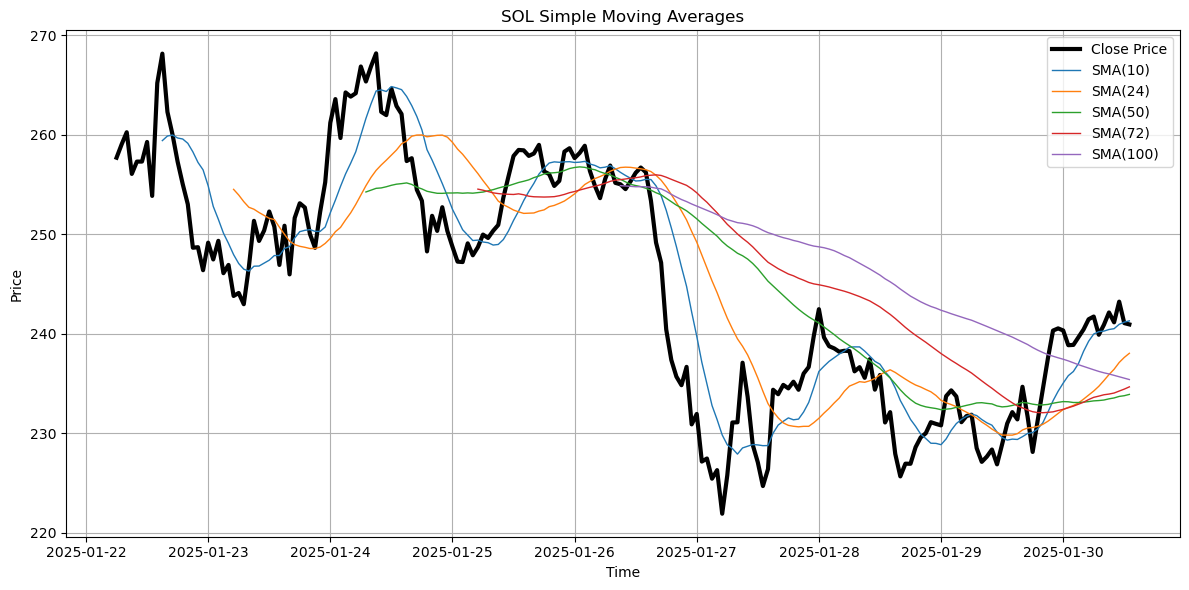

In [70]:
def plot_sma(df, crypto, windows):
    """
    Compute and plot moving averages for given windows.

    Args:
        df (pd.DataFrame): DataFrame containing price data with 'utc_dt' and 'close'.
        crypto (str): Name of the cryptocurrency for the plot title.
        windows (list of int): List of window sizes for calculating moving averages.
    """
    # Create a figure
    plt.figure(figsize=(12,6))
    
    # Plot the closing price
    plt.plot(df['nyc_dt'], df['close'], label='Close Price', color='black', linewidth=3)
    
    # Calculate and plot each moving average
    for window in windows:
        ma_column = f'ma_{window}'
        df[ma_column] = df['close'].rolling(window=window).mean()
        plt.plot(df['nyc_dt'], df[ma_column], label=f'SMA({window})', linewidth=1)

    # Customize the plot
    plt.title(f'{crypto} Simple Moving Averages')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

windows = [10, 24, 50, 72, 100]
plt_df = df[-200:].copy()
plot_sma(plt_df, crypto=f"{crypto}", windows=windows)

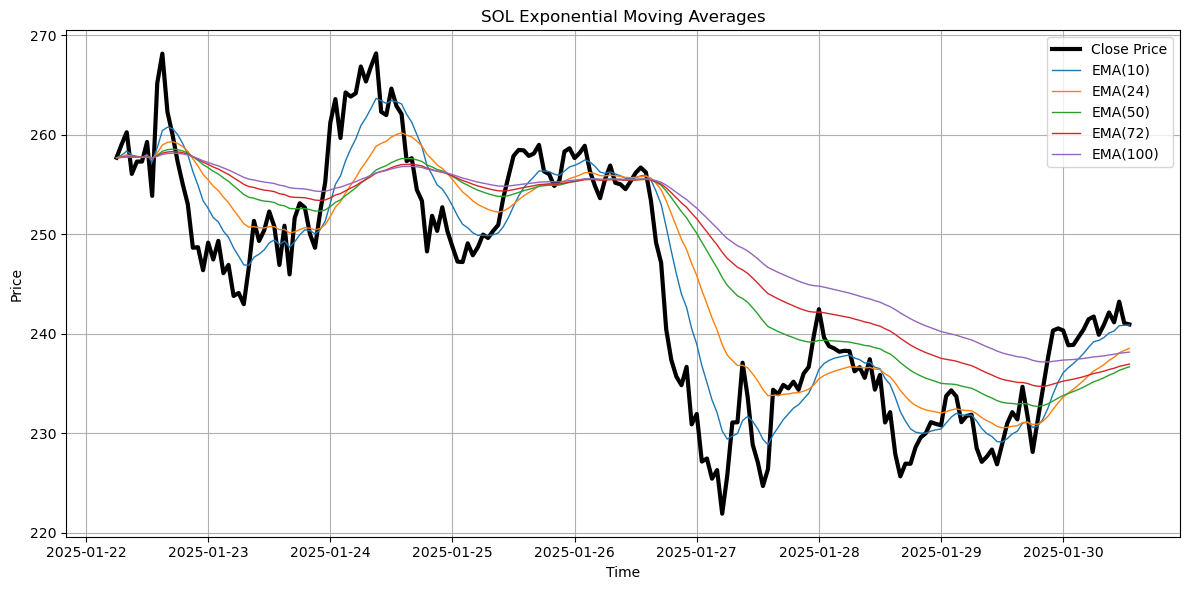

In [71]:
def plot_ema(df, crypto, windows):
    """
    Compute and plot moving averages for given windows.

    Args:
        df (pd.DataFrame): DataFrame containing price data with 'utc_dt' and 'close'.
        crypto (str): Name of the cryptocurrency for the plot title.
        windows (list of int): List of window sizes for calculating moving averages.
    """
    # Create a figure
    plt.figure(figsize=(12,6))
    
    # Plot the closing price
    plt.plot(df['nyc_dt'], df['close'], label='Close Price', color='black', linewidth=3)
    
    # Calculate and plot each moving average
    for window in windows:
        ma_column = f'ma_{window}'
        df[ma_column] = df['close'].ewm(span=window,adjust=False).mean()
        plt.plot(df['nyc_dt'], df[ma_column], label=f'EMA({window})', linewidth=1)

    # Customize the plot
    plt.title(f'{crypto} Exponential Moving Averages')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

windows = [10, 24, 50, 72, 100]
plt_df = df[-200:].copy()
plot_ema(plt_df, crypto=f"{crypto}", windows=windows)

#### 2. RSI (Relative Strength Index)
The RSI is a **momentum oscillator**, and is calculated using the following formula:
- RSI = 100 - 100/(1+RS) , Where RS = avg gain (U) / avg loss (D)

RSI indicates:
- Overbought (>70) or oversold (<30)
- Potential trend reversals
- Midline (50): crossing upward 50 suggests bullish momentum, vice versa
- Divergence: when price moves in the opposite direction of RSI:
  - Bullish Divergence: Price makes lower lows, but RSI makes higher lows → potential upward reversal.
  - Bearish Divergence: Price makes higher highs, but RSI makes lower highs → potential downward reversal.

RSI for decision-making:
- buy when RSI < 30 and shows upward reversal, and sell when RSI > 70 and shows downward reversal
- confirm with other indicators such as MACD and Bollinger Bands
- validate trend: RSI>50 during uptrend reinforces bullish, and RSI<50 during downtrend reinforces bearish 

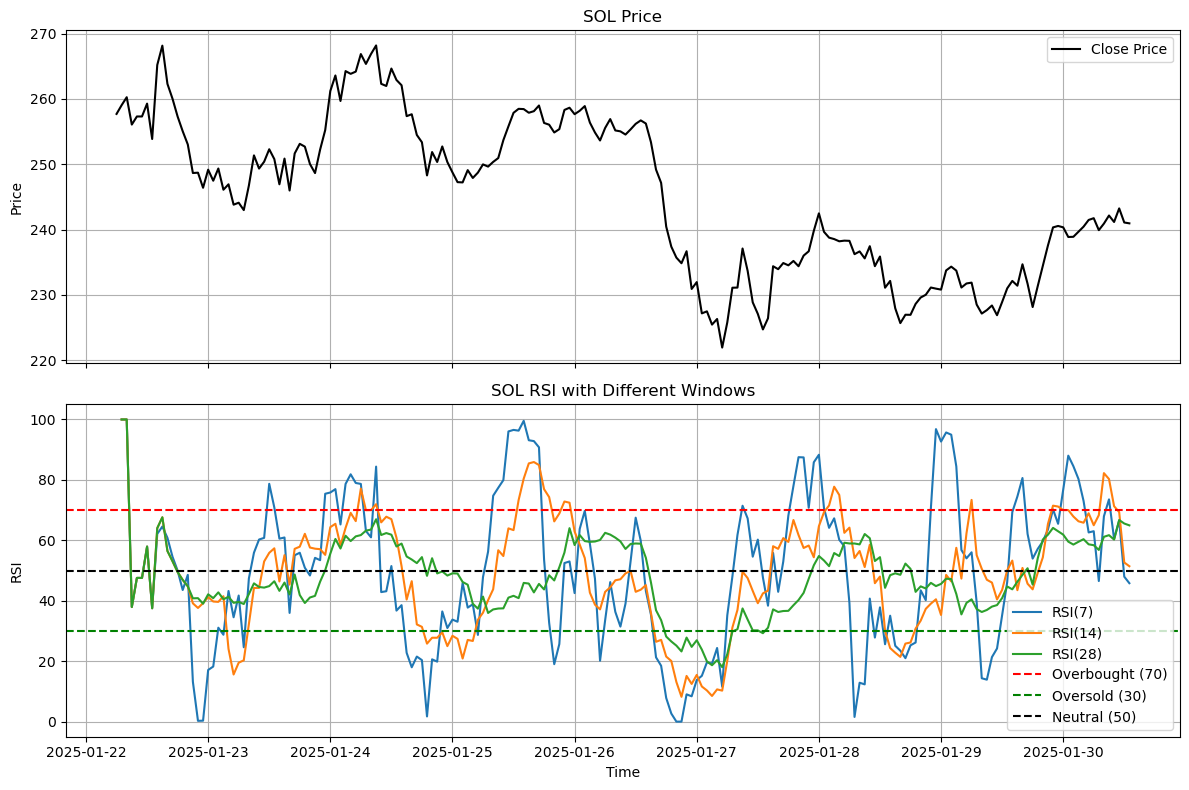

In [72]:
def compute_rsi(df, window=14):
    """
    Compute the Relative Strength Index (RSI).

    Args:
        df (pd.DataFrame): DataFrame containing a 'close' column.
        window (int): Lookback period for RSI calculation.

    Returns:
        pd.Series: RSI values.
    """
    # Calculate price changes
    delta = df['close'].diff()

    # Calculate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate average gains and losses
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calculate RS
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

def plot_rsi(df, crypto, windows):
    """
    Compute and plot RSI for multiple windows.

    Args:
        df (pd.DataFrame): DataFrame containing price data with 'utc_dt' and 'close'.
        crypto (str): Cryptocurrency name for the plot title.
        windows (list of int): List of window sizes for calculating RSI.
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)
    
    # Plot price in the first subplot
    axes[0].plot(df['nyc_dt'], df['close'], label='Close Price', color='black')
    axes[0].set_title(f'{crypto} Price')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot RSI in the second subplot
    for window in windows:
        rsi_column = f'rsi_{window}'
        df[rsi_column] = compute_rsi(df, window=window)
        axes[1].plot(df['nyc_dt'], df[rsi_column], label=f'RSI({window})')
    
    # Add horizontal lines for overbought and oversold levels
    axes[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
    axes[1].axhline(30, color='green', linestyle='--', label='Oversold (30)')
    axes[1].axhline(50, color='black', linestyle='--', label='Neutral (50)')
    
    # Customize the RSI plot
    axes[1].set_title(f'{crypto} RSI with Different Windows')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('RSI')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

windows = [7, 14, 28]
plt_df = df[-200:].copy()
plot_rsi(plt_df, crypto=f"{crypto}", windows=windows)

#### 3. Stochastic Oscillator & Stochastic RSI
Stochastic Oscillator is a momentum indicator:
- %K Line (Fast Stochastic, >80 overbought): (close - lowest low)*100/(highest high - lowest low)
- %D Line (Slow Stochastic, <20 oversold>): SMA of %K, usually 3
- K% and D% crossover generate trading signals  

Stochastic RSI: Stochastic Oscillator applied to RSI values instead of price
- 0.8 indicates overbought, and < 0.2 indicates oversold

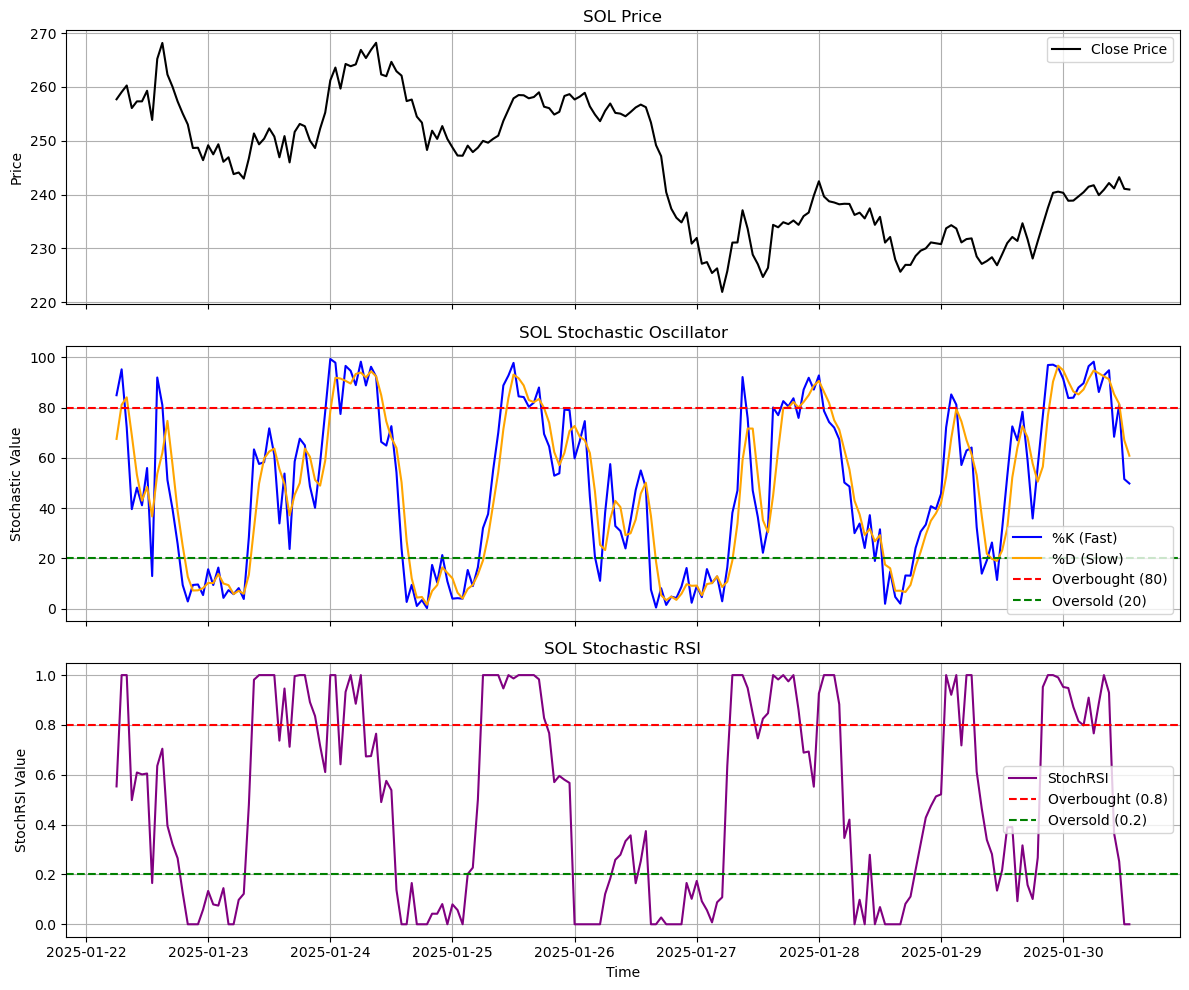

In [73]:
def compute_stochastic_oscillator(df, window=14, smooth_k=3):
    """
    Compute the Stochastic Oscillator.

    Args:
        df (pd.DataFrame): DataFrame containing 'high', 'low', and 'close' columns.
        window (int): Lookback period for %K calculation.
        smooth_k (int): Smoothing period for %D.

    Returns:
        pd.DataFrame: DataFrame with %K and %D values.
    """
    lowest_low = df['low'].rolling(window=window).min()
    highest_high = df['high'].rolling(window=window).max()
    
    df['stoch_k'] = 100 * (df['close'] - lowest_low) / (highest_high - lowest_low)
    df['stoch_d'] = df['stoch_k'].rolling(window=smooth_k).mean()  # Smooth %K to get %D
    return df

def compute_stoch_rsi(df, window=14):
    """
    Compute the Stochastic RSI.

    Args:
        df (pd.DataFrame): DataFrame containing 'close' column.
        window (int): Lookback period for StochRSI calculation.

    Returns:
        pd.Series: Stochastic RSI values.
    """
    rsi = compute_rsi(df, window)
    min_rsi = rsi.rolling(window=window).min()
    max_rsi = rsi.rolling(window=window).max()
    
    df['stoch_rsi'] = (rsi - min_rsi) / (max_rsi - min_rsi)
    return df

def plot_stoch_indicators(df, crypto):
    """
    Plot price, Stochastic Oscillator, and StochRSI.

    Args:
        df (pd.DataFrame): DataFrame containing 'nyc_dt', 'close', 'stoch_k', 'stoch_d', and 'stoch_rsi'.
        crypto (str): Cryptocurrency name for the plot title.
    """
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)

    # Plot price
    axes[0].plot(df['nyc_dt'], df['close'], label='Close Price', color='black')
    axes[0].set_title(f'{crypto} Price')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Stochastic Oscillator
    axes[1].plot(df['nyc_dt'], df['stoch_k'], label='%K (Fast)', color='blue')
    axes[1].plot(df['nyc_dt'], df['stoch_d'], label='%D (Slow)', color='orange')
    axes[1].axhline(80, color='red', linestyle='--', label='Overbought (80)')
    axes[1].axhline(20, color='green', linestyle='--', label='Oversold (20)')
    axes[1].set_title(f'{crypto} Stochastic Oscillator')
    axes[1].set_ylabel('Stochastic Value')
    axes[1].legend()
    axes[1].grid(True)

    # Plot StochRSI
    axes[2].plot(df['nyc_dt'], df['stoch_rsi'], label='StochRSI', color='purple')
    axes[2].axhline(0.8, color='red', linestyle='--', label='Overbought (0.8)')
    axes[2].axhline(0.2, color='green', linestyle='--', label='Oversold (0.2)')
    axes[2].set_title(f'{crypto} Stochastic RSI')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('StochRSI Value')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

df = compute_stochastic_oscillator(df)
df = compute_stoch_rsi(df)
plt_df = df[-200:].copy()
plot_stoch_indicators(plt_df, crypto=f"{crypto}")

#### 4. MACD (Moving Average Convergence Divergence)
How to calculate MACD?
- MACD = EMA(short, e.g. 12) - EMA(long, e.g. 26)
- MACD signal line: EMA(9-period) of MACD line
  
Trading strategies using MACD
1. MACD crossovers: 
   - Bullish & buy signal: MACD crosses above signal
   - Bearish & sell signal: MACD crosses below signal
2. Zero-line cross:
   - above 0: uptrend is strong
   - below 0: downtrend is strong
3. Divergence:
   - Bullish Divergence: Price makes lower lows, but MACD makes higher lows → Potential reversal up.
   - Bearish Divergence: Price makes higher highs, but MACD makes lower highs → Potential reversal down.

Impact of window selection:
- Shorter windows (e.g., 6-13-5): more sensitive, faster signals, but more false signals
- Standard windows (e.g., 12-26-9): good balance between responsiveness and noise reduction
- Longer windows (e.g. 20-50-10): generating fewer signals, detecting long-term trend

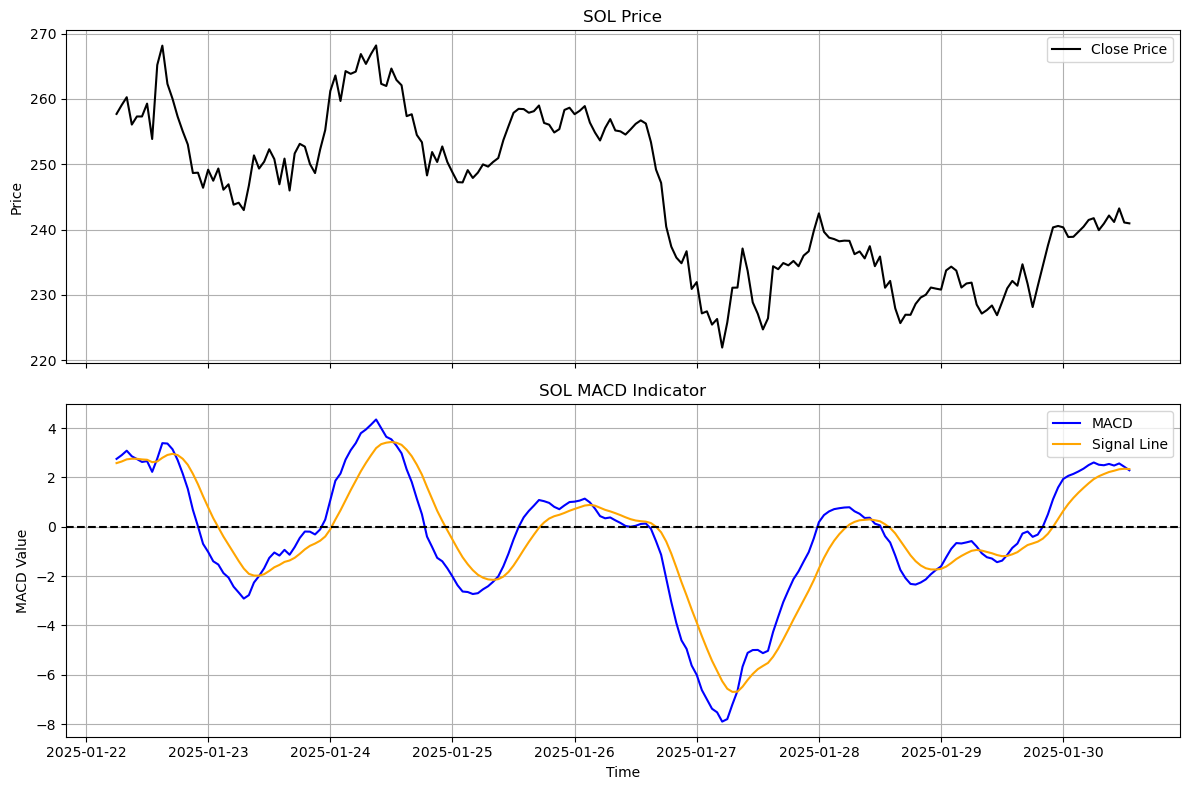

In [74]:
def compute_macd(df, short_window=12, long_window=26, signal_window=9):
    """
    Compute MACD (Moving Average Convergence Divergence) and signal line.

    Args:
        df (pd.DataFrame): DataFrame containing 'close' column.
        short_window (int): Period for short-term EMA (default: 12).
        long_window (int): Period for long-term EMA (default: 26).
        signal_window (int): Period for signal line EMA (default: 9).

    Returns:
        pd.DataFrame: DataFrame with 'macd' and 'macd_signal' columns.
    """
    df['ema_short'] = df['close'].ewm(span=short_window, adjust=False).mean()
    df['ema_long'] = df['close'].ewm(span=long_window, adjust=False).mean()
    df['macd'] = df['ema_short'] - df['ema_long']
    df['macd_signal'] = df['macd'].ewm(span=signal_window, adjust=False).mean()
    return df

def plot_macd(df, crypto):
    """
    Plot MACD and Signal Line along with the price.

    Args:
        df (pd.DataFrame): DataFrame containing 'nyc_dt', 'close', 'macd', and 'macd_signal'.
        crypto (str): Cryptocurrency name for the plot title.
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

    # Plot price
    axes[0].plot(df['nyc_dt'], df['close'], label='Close Price', color='black')
    axes[0].set_title(f'{crypto} Price')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True)

    # Plot MACD and Signal Line
    axes[1].plot(df['nyc_dt'], df['macd'], label='MACD', color='blue')
    axes[1].plot(df['nyc_dt'], df['macd_signal'], label='Signal Line', color='orange')
    axes[1].axhline(0, color='black', linestyle='--')
    axes[1].set_title(f'{crypto} MACD Indicator')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('MACD Value')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

df = compute_macd(df)
plt_df = df[-200:].copy()
plot_macd(plt_df, crypto=f"{crypto}")

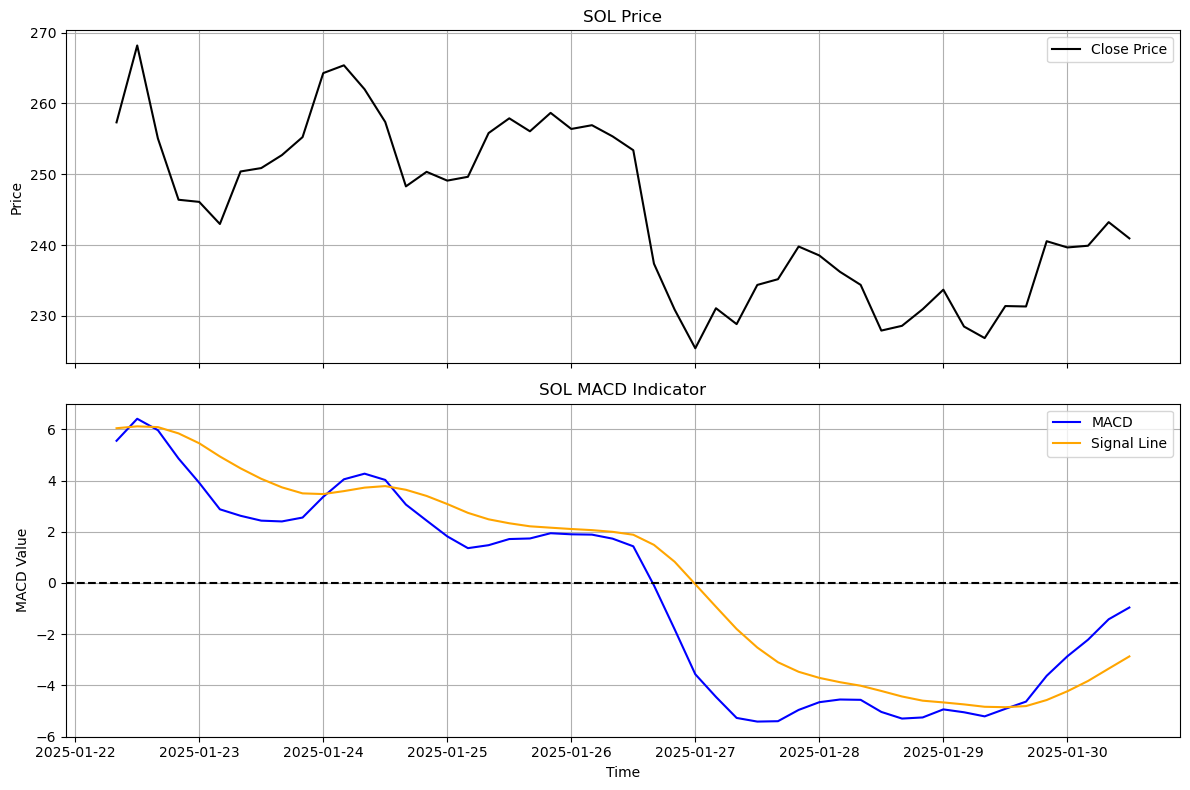

In [75]:
# see MACD for 4h data
def resample_to_4h(df):
    """
    Resample hourly data into 4-hour intervals.

    Args:
        df (pd.DataFrame): DataFrame containing hourly price data.

    Returns:
        pd.DataFrame: DataFrame resampled to 4-hour intervals.
    """
    df_4h = df.resample('4H', on='nyc_dt').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volumefrom': 'sum',
        'volumeto': 'sum',
        'avg': 'mean'
    }).dropna().reset_index()
    
    return df_4h

# Convert hourly data to 4-hour timeframe
df_4h = resample_to_4h(df)

# plot 4 hour MACD
df_4h = compute_macd(df_4h)
plt_df = df_4h[-50:].copy()
plot_macd(plt_df, crypto=f"{crypto}")

#### 5. ADX (Average Directional Index)
ADX measures trend **strength** rather than direction. 

ADX is derived from: **+DI (Positive Directional Indicator)** and **-DI (Negative Directional Indicator)**

Use ADX for trading:
|ADX Value|	Trend Strength	|Strategy|
|---|---|---|
|ADX < 20|	Weak trend (sideways market)|	Avoid trend-based strategies|
|ADX 20-25|	Uncertain trend strength|	Confirm with other indicators|
|ADX > 25	|Strong trend (bullish or bearish)	|Use trend-following strategies|
|ADX Rising	|Strengthening trend	|Enter with trend direction|
|ADX Falling|	Weakening trend	|Consider exiting positions|

Must also combine with other indicators!

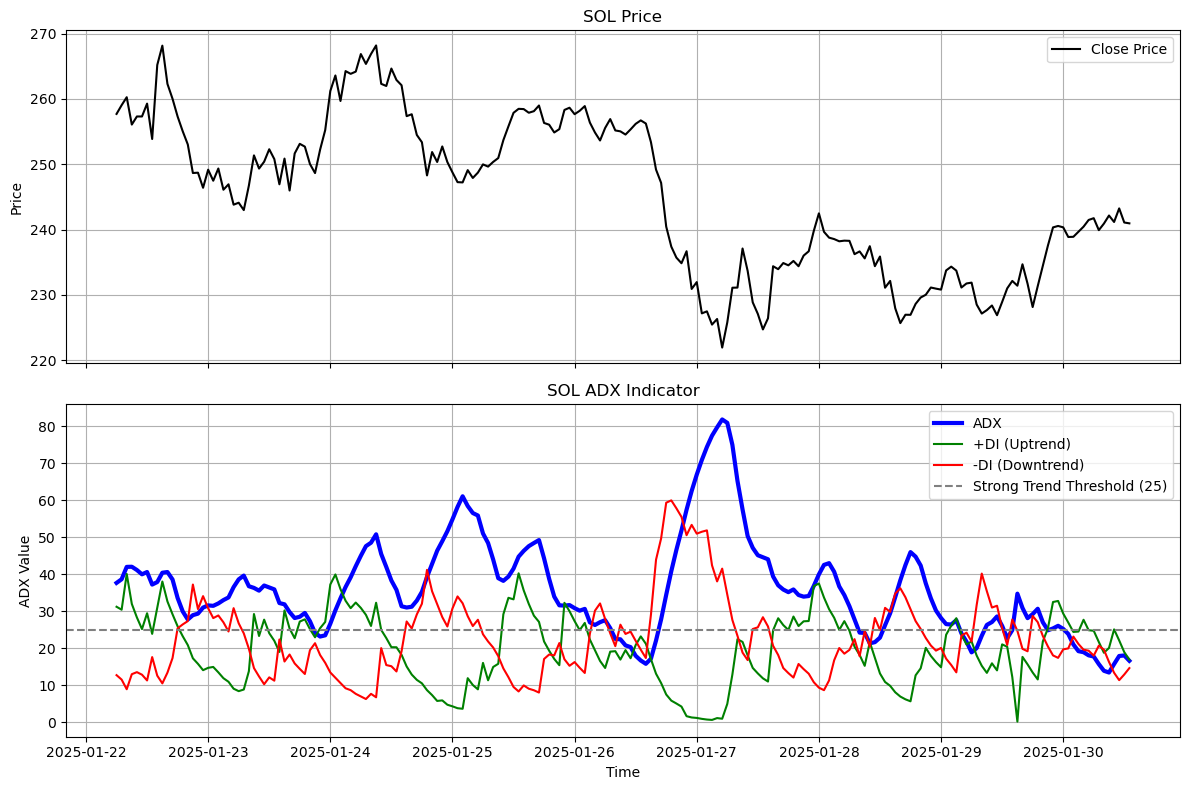

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_adx(df, window=14):
    """
    Compute the ADX (Average Directional Index), +DI, and -DI.

    Args:
        df (pd.DataFrame): DataFrame containing 'high', 'low', and 'close' columns.
        window (int): Lookback period for ADX calculation.

    Returns:
        pd.DataFrame: DataFrame with ADX, +DI, and -DI values.
    """
    # Calculate True Range (TR)
    df['tr'] = np.maximum(df['high'] - df['low'], 
                          np.maximum(abs(df['high'] - df['close'].shift(1)), 
                                     abs(df['low'] - df['close'].shift(1))))

    # Calculate Directional Movements (+DM and -DM)
    df['+dm'] = np.where((df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']), 
                         df['high'] - df['high'].shift(1), 0)
    df['-dm'] = np.where((df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)), 
                         df['low'].shift(1) - df['low'], 0)

    # Smooth TR, +DM, and -DM using exponential moving average (EMA)
    df['tr_ema'] = df['tr'].ewm(span=window, adjust=False).mean()
    df['+dm_ema'] = df['+dm'].ewm(span=window, adjust=False).mean()
    df['-dm_ema'] = df['-dm'].ewm(span=window, adjust=False).mean()

    # Compute +DI and -DI
    df['+di'] = (df['+dm_ema'] / df['tr_ema']) * 100
    df['-di'] = (df['-dm_ema'] / df['tr_ema']) * 100

    # Compute ADX
    df['dx'] = (abs(df['+di'] - df['-di']) / (df['+di'] + df['-di'])) * 100
    df['adx'] = df['dx'].ewm(span=window, adjust=False).mean()

    return df

def plot_adx(df, crypto):
    """
    Plot ADX, +DI, and -DI along with the price.

    Args:
        df (pd.DataFrame): DataFrame containing 'nyc_dt', 'close', 'adx', '+di', and '-di'.
        crypto (str): Cryptocurrency name for the plot title.
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

    # Plot price
    axes[0].plot(df['nyc_dt'], df['close'], label='Close Price', color='black')
    axes[0].set_title(f'{crypto} Price')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True)

    # Plot ADX, +DI, and -DI
    axes[1].plot(df['nyc_dt'], df['adx'], label='ADX', color='blue', linewidth=3)
    axes[1].plot(df['nyc_dt'], df['+di'], label='+DI (Uptrend)', color='green')
    axes[1].plot(df['nyc_dt'], df['-di'], label='-DI (Downtrend)', color='red')
    axes[1].axhline(25, color='gray', linestyle='--', label='Strong Trend Threshold (25)')
    axes[1].set_title(f'{crypto} ADX Indicator')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('ADX Value')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

df = compute_adx(df)
plt_df = df[-200:].copy()
plot_adx(plt_df, crypto=f"{crypto}")


#### 6. Williams %R
Williams Percent Range is a **momemtum** indicator
- Williams %R = -100*(Highest High - Close)/(Highest High - Lowest Low)
- Range: -100 ~ 0
- above -20: overbought; below -80: oversold
- faster and more sensitive than Stochastic Oscillator

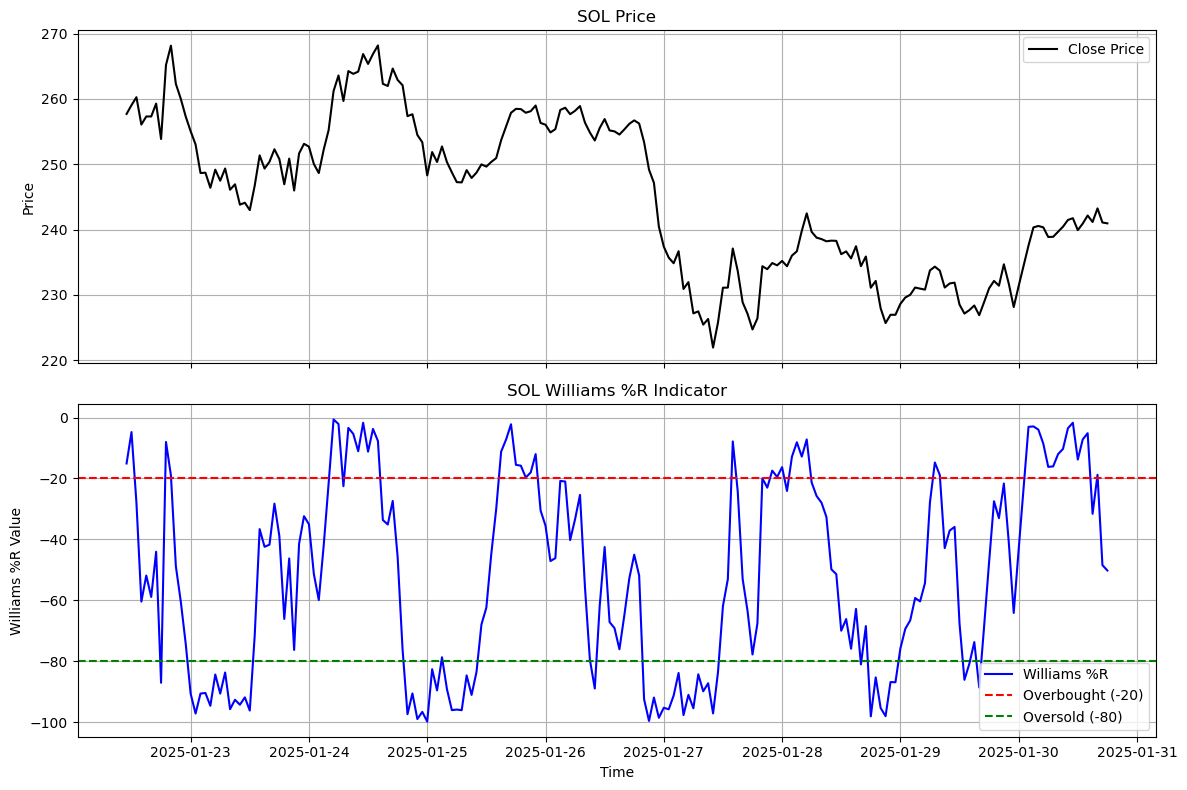

In [77]:
def compute_williams_r(df, window=14):
    """
    Compute Williams %R indicator.

    Args:
        df (pd.DataFrame): DataFrame containing 'high', 'low', and 'close' columns.
        window (int): Lookback period for Williams %R calculation.

    Returns:
        pd.DataFrame: DataFrame with Williams %R values.
    """
    highest_high = df['high'].rolling(window=window).max()
    lowest_low = df['low'].rolling(window=window).min()
    
    df['williams_r'] = -100 * (highest_high - df['close']) / (highest_high - lowest_low)
    return df

def plot_williams_r(df, crypto):
    """
    Plot Williams %R indicator along with the price.

    Args:
        df (pd.DataFrame): DataFrame containing 'utc_dt', 'close', and 'williams_r'.
        crypto (str): Cryptocurrency name for the plot title.
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

    # Plot price
    axes[0].plot(df['utc_dt'], df['close'], label='Close Price', color='black')
    axes[0].set_title(f'{crypto} Price')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Williams %R
    axes[1].plot(df['utc_dt'], df['williams_r'], label='Williams %R', color='blue')
    axes[1].axhline(-20, color='red', linestyle='--', label='Overbought (-20)')
    axes[1].axhline(-80, color='green', linestyle='--', label='Oversold (-80)')
    axes[1].set_title(f'{crypto} Williams %R Indicator')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Williams %R Value')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
df = compute_williams_r(df)
plt_df = df[-200:].copy()
plot_williams_r(plt_df, crypto=f"{crypto}")

#### 7. CCI (Commodity Channel Index)
CCI = (Typical Price - SMA of TP) / (0.015*Mean Deviation), where TP = (high+low+close)/3

How to interpret CCI:
|CCI Value	|Market Condition	|Potential Trading Signal|
|---|---|---|
|Above +100	|Overbought	|Possible sell signal |
|Below -100	|Oversold	|Possible buy signal |
|Between -100 and +100	|Neutral zone	|No strong momentum detected.|

How CCI differs from RSI and Stochastic:
|Indicator|	Measures|	Best for|
|---|---|---|
|CCI|	Price deviation from the mean|	Detecting trend strength & reversals|
|RSI	|Price momentum	|Overbought/oversold conditions|
|Stochastic|	Price relative to recent high/low	|Short-term entry/exit points|

#### 8. ATR (Average True Range)
ATR = SMA of True Range, where TR = max(High-Low, |High-Previous Close|, |Low-Previous Close|), which is the largest movement

How to interpret ATR:
- High ATR: high volatility, large price swings
- Low ATR: low volatility, small price swings
- ATR rising: more volatile

How Traders Use ATR
1. Setting Stop-Loss Levels
Many traders set stop-loss orders 1.5x or 2x ATR away from entry.
If ATR = $20, a trader might place a stop-loss $30-$40 away.
2. Identifying Volatility Breakouts
Sudden increases in ATR suggest the start of a strong move.
Low ATR values before a price surge indicate potential breakout.
3. Filtering Trend Strength
When combined with moving averages or ADX, ATR helps confirm trend strength.
Low ATR in a trending market suggests a stable trend.
High ATR in a trending market suggests high volatility (potential reversals)

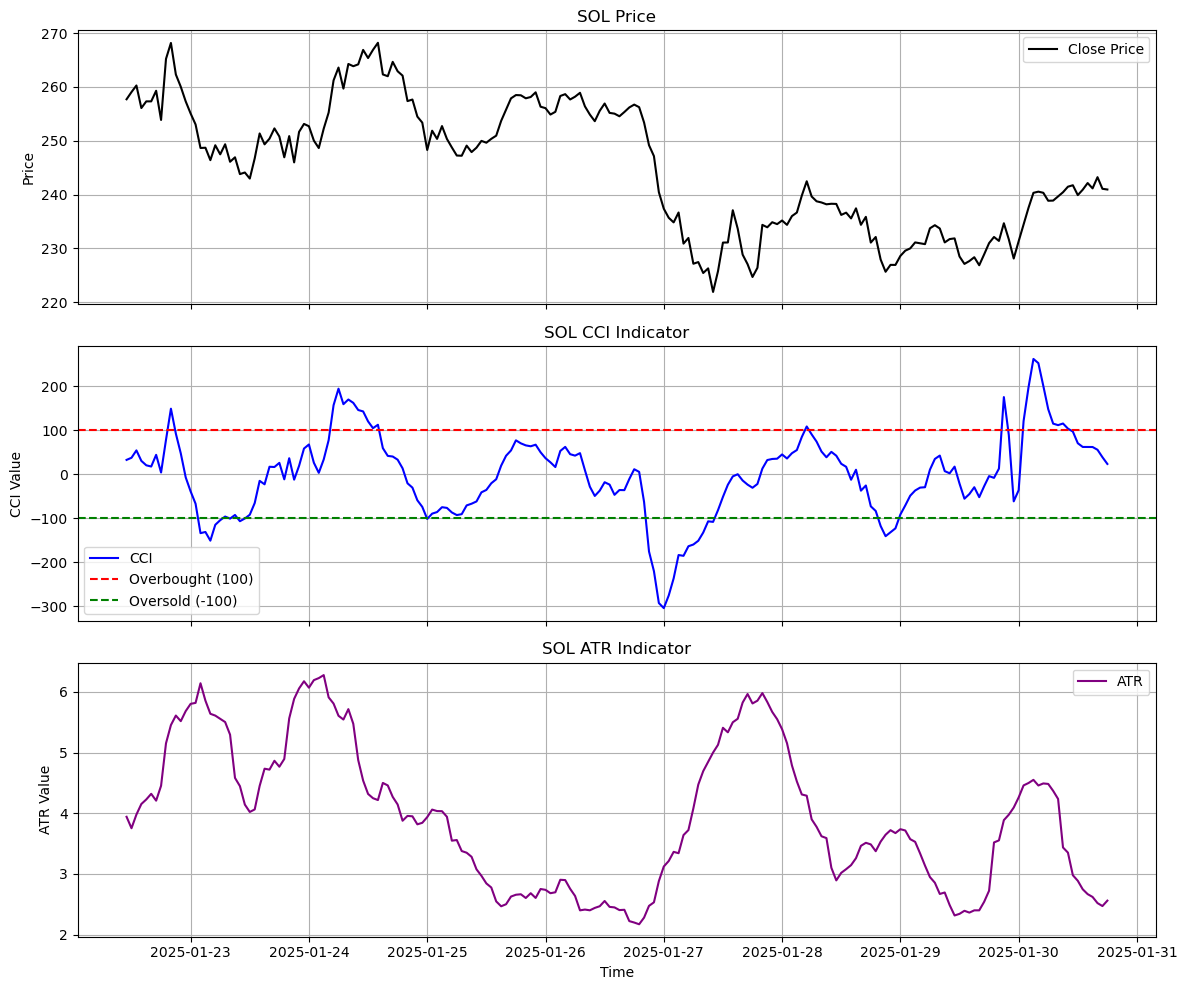

In [78]:
def compute_cci(df, window=20, constant=0.015):
    """
    Compute the Commodity Channel Index (CCI).

    Args:
        df (pd.DataFrame): DataFrame containing 'high', 'low', and 'close' columns.
        window (int): Lookback period for CCI calculation.
        constant (float): Constant used in CCI calculation (default: 0.015).

    Returns:
        pd.DataFrame: DataFrame with CCI values.
    """
    tp = (df['high'] + df['low'] + df['close']) / 3  # Typical Price
    sma_tp = tp.rolling(window=window).mean()  # Simple Moving Average of TP
    mean_dev = (tp - sma_tp).abs().rolling(window=window).mean()  # Mean Deviation
    
    df['cci'] = (tp - sma_tp) / (constant * mean_dev)
    return df

def compute_atr(df, window=14):
    """
    Compute the Average True Range (ATR).

    Args:
        df (pd.DataFrame): DataFrame containing 'high', 'low', and 'close' columns.
        window (int): Lookback period for ATR calculation.

    Returns:
        pd.DataFrame: DataFrame with ATR values.
    """
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift(1))
    tr3 = abs(df['low'] - df['close'].shift(1))
    df['tr'] = np.maximum(tr1, np.maximum(tr2, tr3))
    df['atr'] = df['tr'].rolling(window=window).mean()
    return df

def plot_cci_atr(df, crypto):
    """
    Plot CCI and ATR indicators along with the price.

    Args:
        df (pd.DataFrame): DataFrame containing 'utc_dt', 'close', 'cci', and 'atr'.
        crypto (str): Cryptocurrency name for the plot title.
    """
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)

    # Plot price
    axes[0].plot(df['utc_dt'], df['close'], label='Close Price', color='black')
    axes[0].set_title(f'{crypto} Price')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True)

    # Plot CCI
    axes[1].plot(df['utc_dt'], df['cci'], label='CCI', color='blue')
    axes[1].axhline(100, color='red', linestyle='--', label='Overbought (100)')
    axes[1].axhline(-100, color='green', linestyle='--', label='Oversold (-100)')
    axes[1].set_title(f'{crypto} CCI Indicator')
    axes[1].set_ylabel('CCI Value')
    axes[1].legend()
    axes[1].grid(True)

    # Plot ATR
    axes[2].plot(df['utc_dt'], df['atr'], label='ATR', color='purple')
    axes[2].set_title(f'{crypto} ATR Indicator')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('ATR Value')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
df = compute_cci(df)
df = compute_atr(df)
plt_df = df[-200:].copy()
plot_cci_atr(plt_df, crypto=f"{crypto}")

#### 9. Rolling Highs and Lows
How Traders Use Rolling Highs and Lows

Breakout Trading
- If price breaks above the rolling high → Bullish breakout → Buy.
- If price breaks below the rolling low → Bearish breakout → Sell.

Trend Confirmation
- If rolling highs are increasing and rolling lows are also increasing → Uptrend.
- If rolling highs are decreasing and rolling lows are also decreasing → Downtrend.
  
Support & Resistance Trading
- If price bounces off a rolling low, it may be a buy signal.
- If price rejects a rolling high, it may be a sell signal.

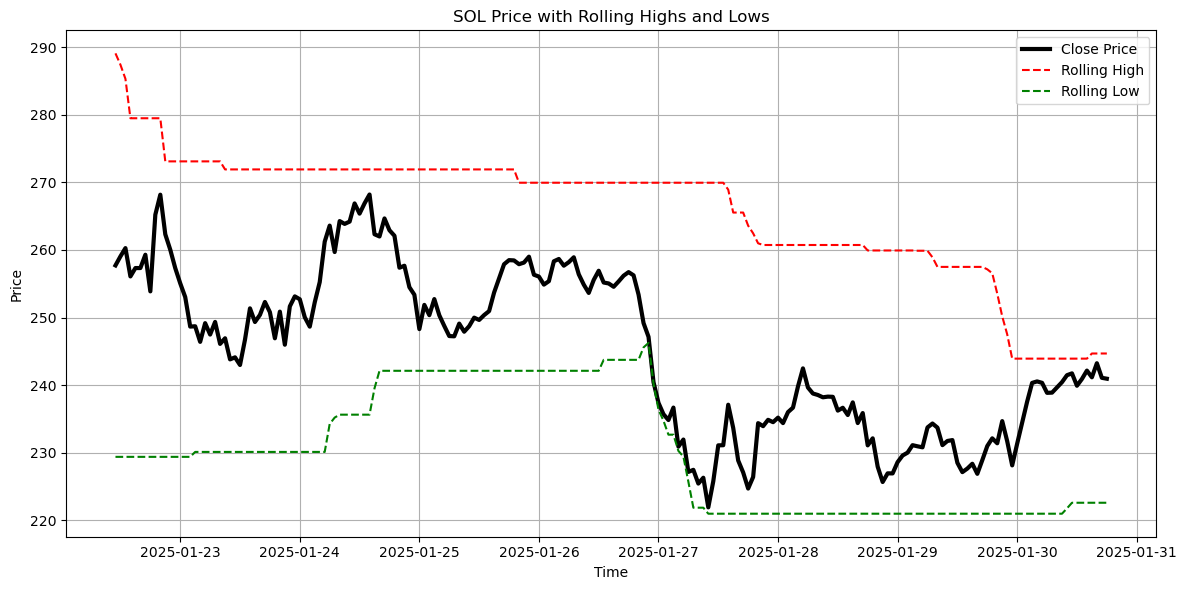

In [79]:
def compute_highs_lows(df, window=20):
    """
    Compute rolling high and low values over a given window.

    Args:
        df (pd.DataFrame): DataFrame containing 'high' and 'low' columns.
        window (int): Lookback period for calculating rolling highs and lows.

    Returns:
        pd.DataFrame: DataFrame with rolling high and low values.
    """
    df['rolling_high'] = df['high'].rolling(window=window).max()
    df['rolling_low'] = df['low'].rolling(window=window).min()
    return df

def plot_highs_lows(df, crypto):
    """
    Plot rolling highs and lows along with the price.

    Args:
        df (pd.DataFrame): DataFrame containing 'utc_dt', 'close', 'rolling_high', and 'rolling_low'.
        crypto (str): Cryptocurrency name for the plot title.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df['utc_dt'], df['close'], label='Close Price', color='black',linewidth=3)
    ax.plot(df['utc_dt'], df['rolling_high'], label='Rolling High', color='red', linestyle='--')
    ax.plot(df['utc_dt'], df['rolling_low'], label='Rolling Low', color='green', linestyle='--')
    ax.set_title(f'{crypto} Price with Rolling Highs and Lows')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
df = compute_highs_lows(df, window=72)
plt_df = df[-200:].copy()
plot_highs_lows(plt_df, crypto=f"{crypto}")

#### 10. Ultimate Oscillator
UO combines short, mid and long term momemtum to reduce false signals

How to interpret UO?
|UO Value	|Market Condition	|Trading Action|
|---|---|---|
|Above 70	|Overbought	|Possible Sell Signal|
|Below 30	|Oversold	|Possible Buy Signal|
|Divergence with Price	|Potential Reversal	|Confirm with other indicators|

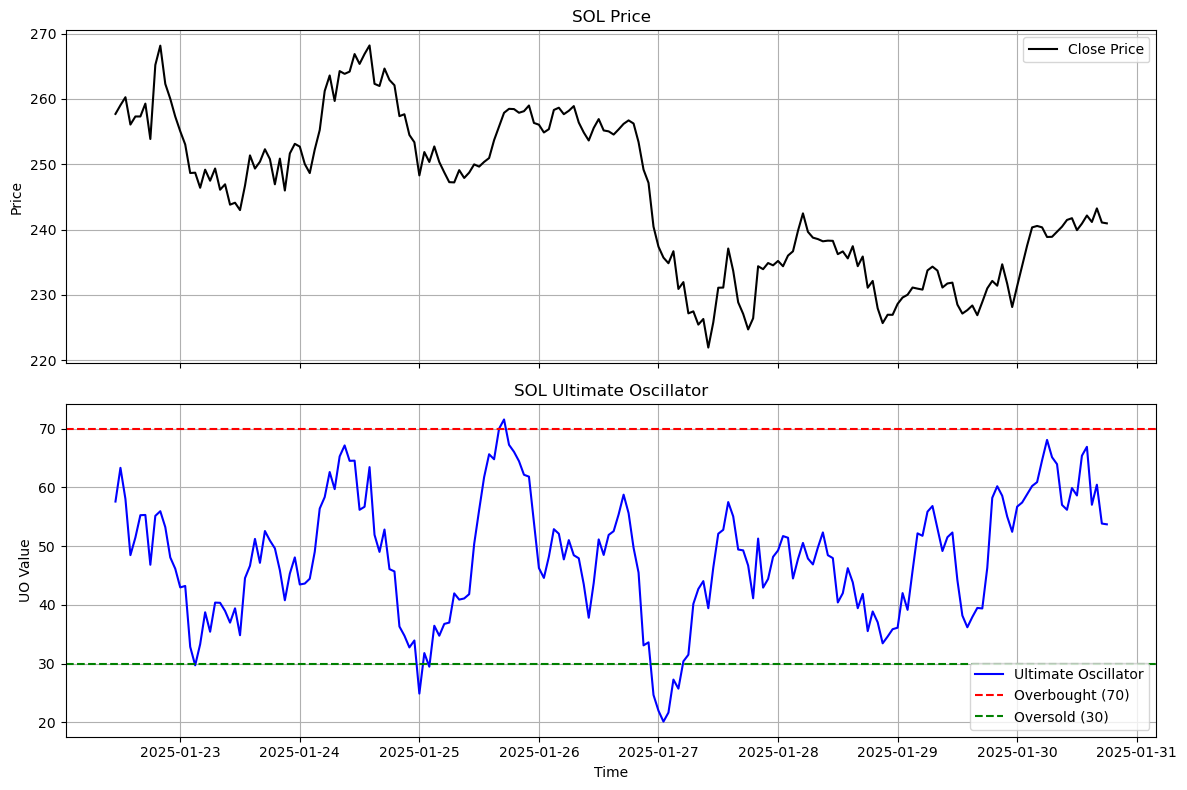

In [80]:
def compute_highs_lows(df, window=20):
    """
    Compute rolling high and low values over a given window.

    Args:
        df (pd.DataFrame): DataFrame containing 'high' and 'low' columns.
        window (int): Lookback period for calculating rolling highs and lows.

    Returns:
        pd.DataFrame: DataFrame with rolling high and low values.
    """
    df['rolling_high'] = df['high'].rolling(window=window).max()
    df['rolling_low'] = df['low'].rolling(window=window).min()
    return df

def compute_ultimate_oscillator(df, short_window=7, mid_window=14, long_window=28):
    """
    Compute the Ultimate Oscillator (UO), a momentum indicator.

    Args:
        df (pd.DataFrame): DataFrame containing 'high', 'low', and 'close' columns.
        short_window (int): Short-term period for calculation (default: 7).
        mid_window (int): Mid-term period for calculation (default: 14).
        long_window (int): Long-term period for calculation (default: 28).

    Returns:
        pd.DataFrame: DataFrame with Ultimate Oscillator values.
    """
    # Calculate Buying Pressure (BP) and True Range (TR)
    df['bp'] = df['close'] - np.minimum(df['low'], df['close'].shift(1))
    df['tr'] = np.maximum(df['high'], df['close'].shift(1)) - np.minimum(df['low'], df['close'].shift(1))
    
    # Calculate weighted averages for three different periods
    short_avg = df['bp'].rolling(short_window).sum() / df['tr'].rolling(short_window).sum()
    mid_avg = df['bp'].rolling(mid_window).sum() / df['tr'].rolling(mid_window).sum()
    long_avg = df['bp'].rolling(long_window).sum() / df['tr'].rolling(long_window).sum()
    
    # Compute Ultimate Oscillator
    df['ultimate_oscillator'] = 100 * ((4 * short_avg) + (2 * mid_avg) + long_avg) / (4 + 2 + 1)
    return df

def plot_ultimate_oscillator(df, crypto):
    """
    Plot Ultimate Oscillator along with the price.

    Args:
        df (pd.DataFrame): DataFrame containing 'utc_dt', 'close', and 'ultimate_oscillator'.
        crypto (str): Cryptocurrency name for the plot title.
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

    # Plot price
    axes[0].plot(df['utc_dt'], df['close'], label='Close Price', color='black')
    axes[0].set_title(f'{crypto} Price')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Ultimate Oscillator
    axes[1].plot(df['utc_dt'], df['ultimate_oscillator'], label='Ultimate Oscillator', color='blue')
    axes[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
    axes[1].axhline(30, color='green', linestyle='--', label='Oversold (30)')
    axes[1].set_title(f'{crypto} Ultimate Oscillator')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('UO Value')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
df = compute_highs_lows(df)
df = compute_ultimate_oscillator(df)
plt_df = df[-200:].copy()
plot_ultimate_oscillator(plt_df, crypto=f"{crypto}")

#### 11. Pivot Points
Pivot points are used in technical analysis to identify potential support and resistance levels. They help traders determine reversal points, breakout levels, and overall market sentiment.

Pivot Point (PP) = (High+Low+Close)/3

1. **Classic** (Standard) Pivot Points, Support/Resistance Levels
- R1 = 2*PP - Low
- R2 = PP + (High-Low)
- R3 = High + 2*(PP-Low)
- S1 = 2*PP - High
- S2 = PP - (High-Low)
- S3 = Low - 2*(High-PP)
2. Fibonnacci Pivot Points, Support/Resistance Levels
- R1/S1 = PP +/- 0.382*(High-Low)
- R2/S2 = PP +/- 0.618*(High-Low)
- R3/S3 = PP +/- 1*(High-Low)
3. Camarilla Pivot Points, Support/Resistance Levels
- R1/S1 = Close +/- 1.1*(High-Low)/12
- R2/S2 = Close +/- 1.1*(High-Low)/6
- R3/S3 = Close +/- 1.1*(High-Low)/4
4. Woodie's Pivot Points, Support/Resistance Levels
- R1 = 2*PP - Low
- R2 = PP + (High-Low)
- S1 = 2*PP - High
- S2 = PP - (High-Low)
5. DeMark's Pivot Points, Support/Resistance Levels

How to Use Pivot Points in Trading
|Pivot Level	|Trading Action|
|---|---|
|Price above pivot point (PP)|	Market is bullish (look for buy signals)|
|Price below pivot point (PP)	|Market is bearish (look for sell signals)|
|Price near resistance (R1, R2, R3, etc.)	|Consider selling or shorting|
|Price near support (S1, S2, S3, etc.)|	Consider buying|

Which Pivot Points Should You Use?
- Classic Pivot Points → General trading.
- Fibonacci Pivot Points → Retracement-based strategies.
- Camarilla Pivot Points → Short-term trading.
- Woodie’s Pivot Points → Volatile markets.
- DeMark’s Pivot Points → Trend reversals.

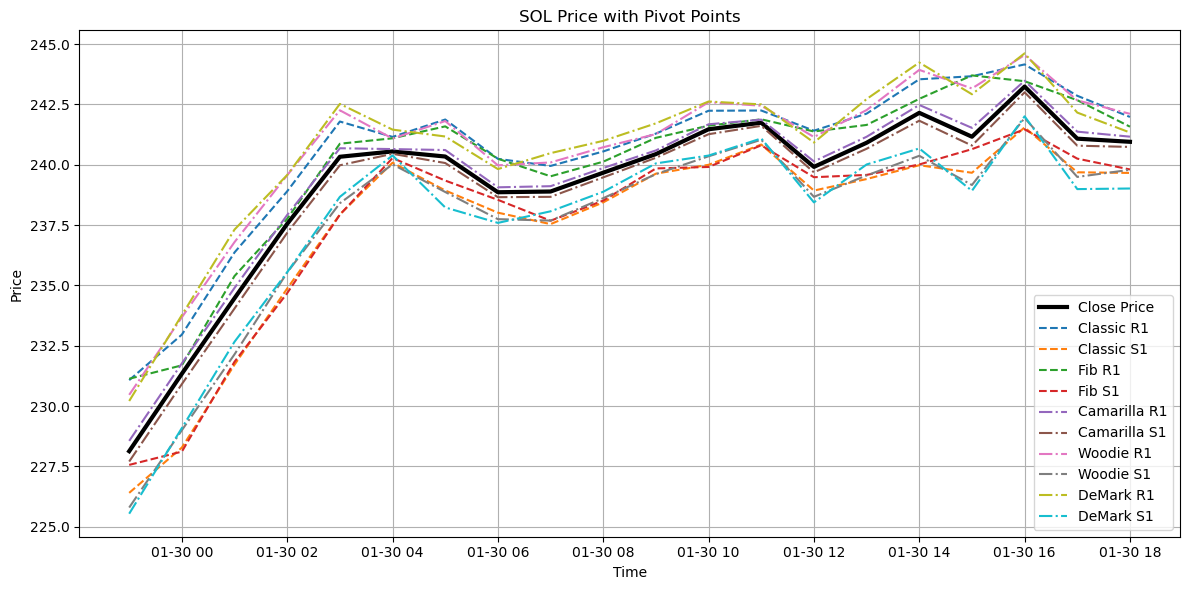

In [86]:
def compute_pivot_points(df):
    """
    Compute multiple types of Pivot Points including Classic, Fibonacci, Camarilla, Woodie's, and DeMark's levels.

    Args:
        df (pd.DataFrame): DataFrame containing 'high', 'low', and 'close' columns.

    Returns:
        pd.DataFrame: DataFrame with Pivot Points and support/resistance levels.
    """
    # Classic Pivot Points
    df['pp'] = (df['high'] + df['low'] + df['close']) / 3
    df['r1'] = (2 * df['pp']) - df['low']
    df['r2'] = df['pp'] + (df['high'] - df['low'])
    df['r3'] = df['high'] + 2 * (df['pp'] - df['low'])
    df['s1'] = (2 * df['pp']) - df['high']
    df['s2'] = df['pp'] - (df['high'] - df['low'])
    df['s3'] = df['low'] - 2 * (df['high'] - df['pp'])
    
    # Fibonacci Pivot Points
    df['fib_r1'] = df['pp'] + 0.382 * (df['high'] - df['low'])
    df['fib_r2'] = df['pp'] + 0.618 * (df['high'] - df['low'])
    df['fib_r3'] = df['pp'] + 1.000 * (df['high'] - df['low'])
    df['fib_s1'] = df['pp'] - 0.382 * (df['high'] - df['low'])
    df['fib_s2'] = df['pp'] - 0.618 * (df['high'] - df['low'])
    df['fib_s3'] = df['pp'] - 1.000 * (df['high'] - df['low'])
    
    # Camarilla Pivot Points
    df['cam_r1'] = df['close'] + (1.1 * (df['high'] - df['low']) / 12)
    df['cam_r2'] = df['close'] + (1.1 * (df['high'] - df['low']) / 6)
    df['cam_r3'] = df['close'] + (1.1 * (df['high'] - df['low']) / 4)
    df['cam_r4'] = df['close'] + (1.1 * (df['high'] - df['low']) / 2)
    df['cam_s1'] = df['close'] - (1.1 * (df['high'] - df['low']) / 12)
    df['cam_s2'] = df['close'] - (1.1 * (df['high'] - df['low']) / 6)
    df['cam_s3'] = df['close'] - (1.1 * (df['high'] - df['low']) / 4)
    df['cam_s4'] = df['close'] - (1.1 * (df['high'] - df['low']) / 2)
    
    # Woodie's Pivot Points
    df['woodie_pp'] = (df['high'] + df['low'] + 2 * df['close']) / 4
    df['woodie_r1'] = (2 * df['woodie_pp']) - df['low']
    df['woodie_s1'] = (2 * df['woodie_pp']) - df['high']
    
    # DeMark's Pivot Points
    x = np.where(df['close'] < df['open'], df['high'] + (2 * df['low']) + df['close'],
                 np.where(df['close'] > df['open'], (2 * df['high']) + df['low'] + df['close'],
                          df['high'] + df['low'] + (2 * df['close'])))
    df['demark_pp'] = x / 4
    df['demark_r1'] = x / 2 - df['low']
    df['demark_s1'] = x / 2 - df['high']
    
    return df

def plot_pivot_points(df, crypto):
    """
    Plot price along with multiple Pivot Points.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df['utc_dt'], df['close'], label='Close Price', color='black', linewidth=3)
    ax.plot(df['utc_dt'], df['r1'], label='Classic R1', linestyle='--')
    ax.plot(df['utc_dt'], df['s1'], label='Classic S1', linestyle='--')
    ax.plot(df['utc_dt'], df['fib_r1'], label='Fib R1', linestyle='--')
    ax.plot(df['utc_dt'], df['fib_s1'], label='Fib S1', linestyle='--')
    ax.plot(df['utc_dt'], df['cam_r1'], label='Camarilla R1', linestyle='-.')
    ax.plot(df['utc_dt'], df['cam_s1'], label='Camarilla S1', linestyle='-.')
    ax.plot(df['utc_dt'], df['woodie_r1'], label='Woodie R1', linestyle='-.')
    ax.plot(df['utc_dt'], df['woodie_s1'], label='Woodie S1', linestyle='-.')
    ax.plot(df['utc_dt'], df['demark_r1'], label='DeMark R1', linestyle='-.')
    ax.plot(df['utc_dt'], df['demark_s1'], label='DeMark S1', linestyle='-.')
    ax.set_title(f'{crypto} Price with Pivot Points')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
df = compute_pivot_points(df)
plt_df = df[-20:].copy()
plot_pivot_points(plt_df, crypto=f"{crypto}")